# Generic Sensory LPU Demo

This notebook illustrates how to simulate a generic LPU with input from sensory neurons. The generic LPU considered in this example serves as a template of LPU design, and can be extended to other sensory modulaties such as olfaction and vision systems. 

#### Configuration

The generic LPU comprises two populations of neurons: local neurons and output neurons [(Chiang et al., 2011)](#chiang_three-dimensional_2011). In order to provide input into the LPU, we include sensory neurons in this demo. These sensory neurons are driven by an artificial input stimulus. The overall structure of the model is depicted as follows:

<img src='files/files/generic_lpu.png' />

The generic LPU employed in this example is randomly generated; between 30 and 40 neurons are included in each population. The sensory neurons and ouput neurons are modeled using the Leaky Integrate-and-Fire (LIF) neuron model, while each of the local neurons is modeled either as a spiking neuron using the LIF model or a graded potential neuron using the Morris-Lecar model. The synapses across each pairs of neuron populations are also created randomly. Roughly half of the pairs of neurons in the LPU are connected. Assuming that both the ``neurokernel`` and ``neurodriver`` package have been installed and the current working directory is ``neurodriver/notebooks``, we run the following code to generate the LPU configuration and the input stimulus:

In [1]:
import sys
sys.path.append("../examples/generic/data")
sys.path.append("../examples/generic")

#Used to generate pseudo-random numbers
import numpy as np

#Randomly generates an LPU as described above
#Sends outputted graph to a GEXF file
from gen_generic_lpu import create_lpu

#Creates an HDF5 file containing input signals for the specified number of neurons
#The signals consist of a rectangular pulse of specified duration and magnitude
from gen_generic_lpu import create_input

#Define variables for the LPU
random_seed = 1                                           #Random seed for numpy
lpu_file_name = 'generic_lpu.gexf.gz'                     #File to write the LPU graph to
lpu_name = 'test'                                         #Name of the LPU
neu_num = [np.random.randint(31, 40) for i in xrange(3)]  #Number of sensory, local, and projection neurons

#Set a random seed for numpy
np.random.seed(random_seed)

#Create the LPU
create_lpu(file_name = lpu_file_name,
           lpu_name = lpu_name,
           N_sensory = neu_num[0],
           N_local = neu_num[1],
           N_proj = neu_num[2])

#Define variables for the input
in_file_name = 'generic_input.h5'  #File to output the generated input data to
N_sensory = neu_num[0]             #Number of sensory neurons
dt = 1e-4                          #Time resolution of generated signal
dur = 1.0                          #Duration of generated signal
start = 0.3                        #Start time of signal pulse
stop = 0.6                         #Stop time of signal pulse
I_max = 0.6                        #Pulse magnitude

#Create the input data
create_input(file_name = in_file_name,
             N_sensory = N_sensory,
             dt = dt,
             dur = dur,
             start = start,
             stop = stop,
             I_max = I_max)

#### Simulation

Once the configuration and the input stimulus are ready, we execute the entire model:

In [2]:
from neurokernel.tools.mpi_run import *

from neurokernel.tools.logging import setup_logger
import neurokernel.core_gpu as core_gpu

from neurokernel.LPU.LPU import LPU

from neurokernel.LPU.InputProcessors.FileInputProcessor import FileInputProcessor
from neurokernel.LPU.OutputProcessors.FileOutputProcessor import FileOutputProcessor

#Define variables for the process
lpu_file_name = 'generic_lpu.gexf.gz'  #File where the LPU graph is stored
in_file_name = 'generic_input.h5'      #File where the input data is stored
dt = 1e-4                              #Time resolution of generated signal
dur = 1.0                              #Duration of generated signal
gpu_dev = 0                            #GPU device number
steps = int(dur/dt)                    #Number of steps
out_file_name = 'new_output.h5'        #File to send the output data to

#Create a process manager
man = core_gpu.Manager()

#Parse the LPU from GEXF file
(comp_dict, conns) = LPU.lpu_parser(lpu_file_name)

#Input data from HDF5 input file
fl_input_processor = FileInputProcessor(in_file_name)

#Output data to HDF5 file
fl_output_processor = FileOutputProcessor([('V',None),('spike_state',None)], out_file_name, sample_interval=1)

#Add the LPU to the Manager and attach input and output processors to it
man.add(LPU, 'ge', dt, comp_dict, conns,
        device = gpu_dev, input_processors = [fl_input_processor],
        output_processors = [fl_output_processor], debug = True)

#Use mpi_run_manager to execute the manager in notebook
from subprocess import CalledProcessError
try:
    output = mpi_run_manager(man, steps = steps, log = True)
except CalledProcessError:
    with open('neurokernel.log', 'r') as f:
        print f.read()
print(output)

#This should be replaced by the following in regular code
#man.spawn()
#man.start(steps=args.steps)
#man.wait()


MPI_RUN_SUCCESS: MPI_Function



#### Visualizing Result

Next, we render the simulation output to an image:

In [3]:
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt

import neurokernel.LPU.utils.visualizer as vis
import networkx as nx
import h5py

# Temporary fix for bug in networkx 1.8:
nx.readwrite.gexf.GEXF.convert_bool = {'false':False, 'False':False,
                                       'true':True, 'True':True}

# Select IDs of spiking projection neurons:
G = nx.read_gexf(lpu_file_name)
neu_proj = sorted([k for k, n in G.node.items() if \
                   n['name'][:4] == 'proj' and \
                   n['class'] == 'LeakyIAF'])

in_uid = 'sensory_0'

N = len(neu_proj)

V = vis.visualizer()
V.add_LPU(in_file_name, LPU='Sensory', is_input=True)
V.add_plot({'type':'waveform', 'uids': [[in_uid]], 'variable':'I'},
           'input_Sensory')

V.add_LPU(out_file_name,  'Generic LPU',
          gexf_file= lpu_file_name)
V.add_plot({'type':'raster', 'uids': [neu_proj], 'variable': 'spike_state',
            'yticks': range(1, 1+N),
            'yticklabels': neu_proj, 'title': 'Output'},
            'Generic LPU')

V.rows = 2
V.cols = 1
V.fontsize = 8
V.xlim = [0, 1.0]
V.update_interval = None
V.run('generic_output.png')


The simulation output rendered to an image is shown below:

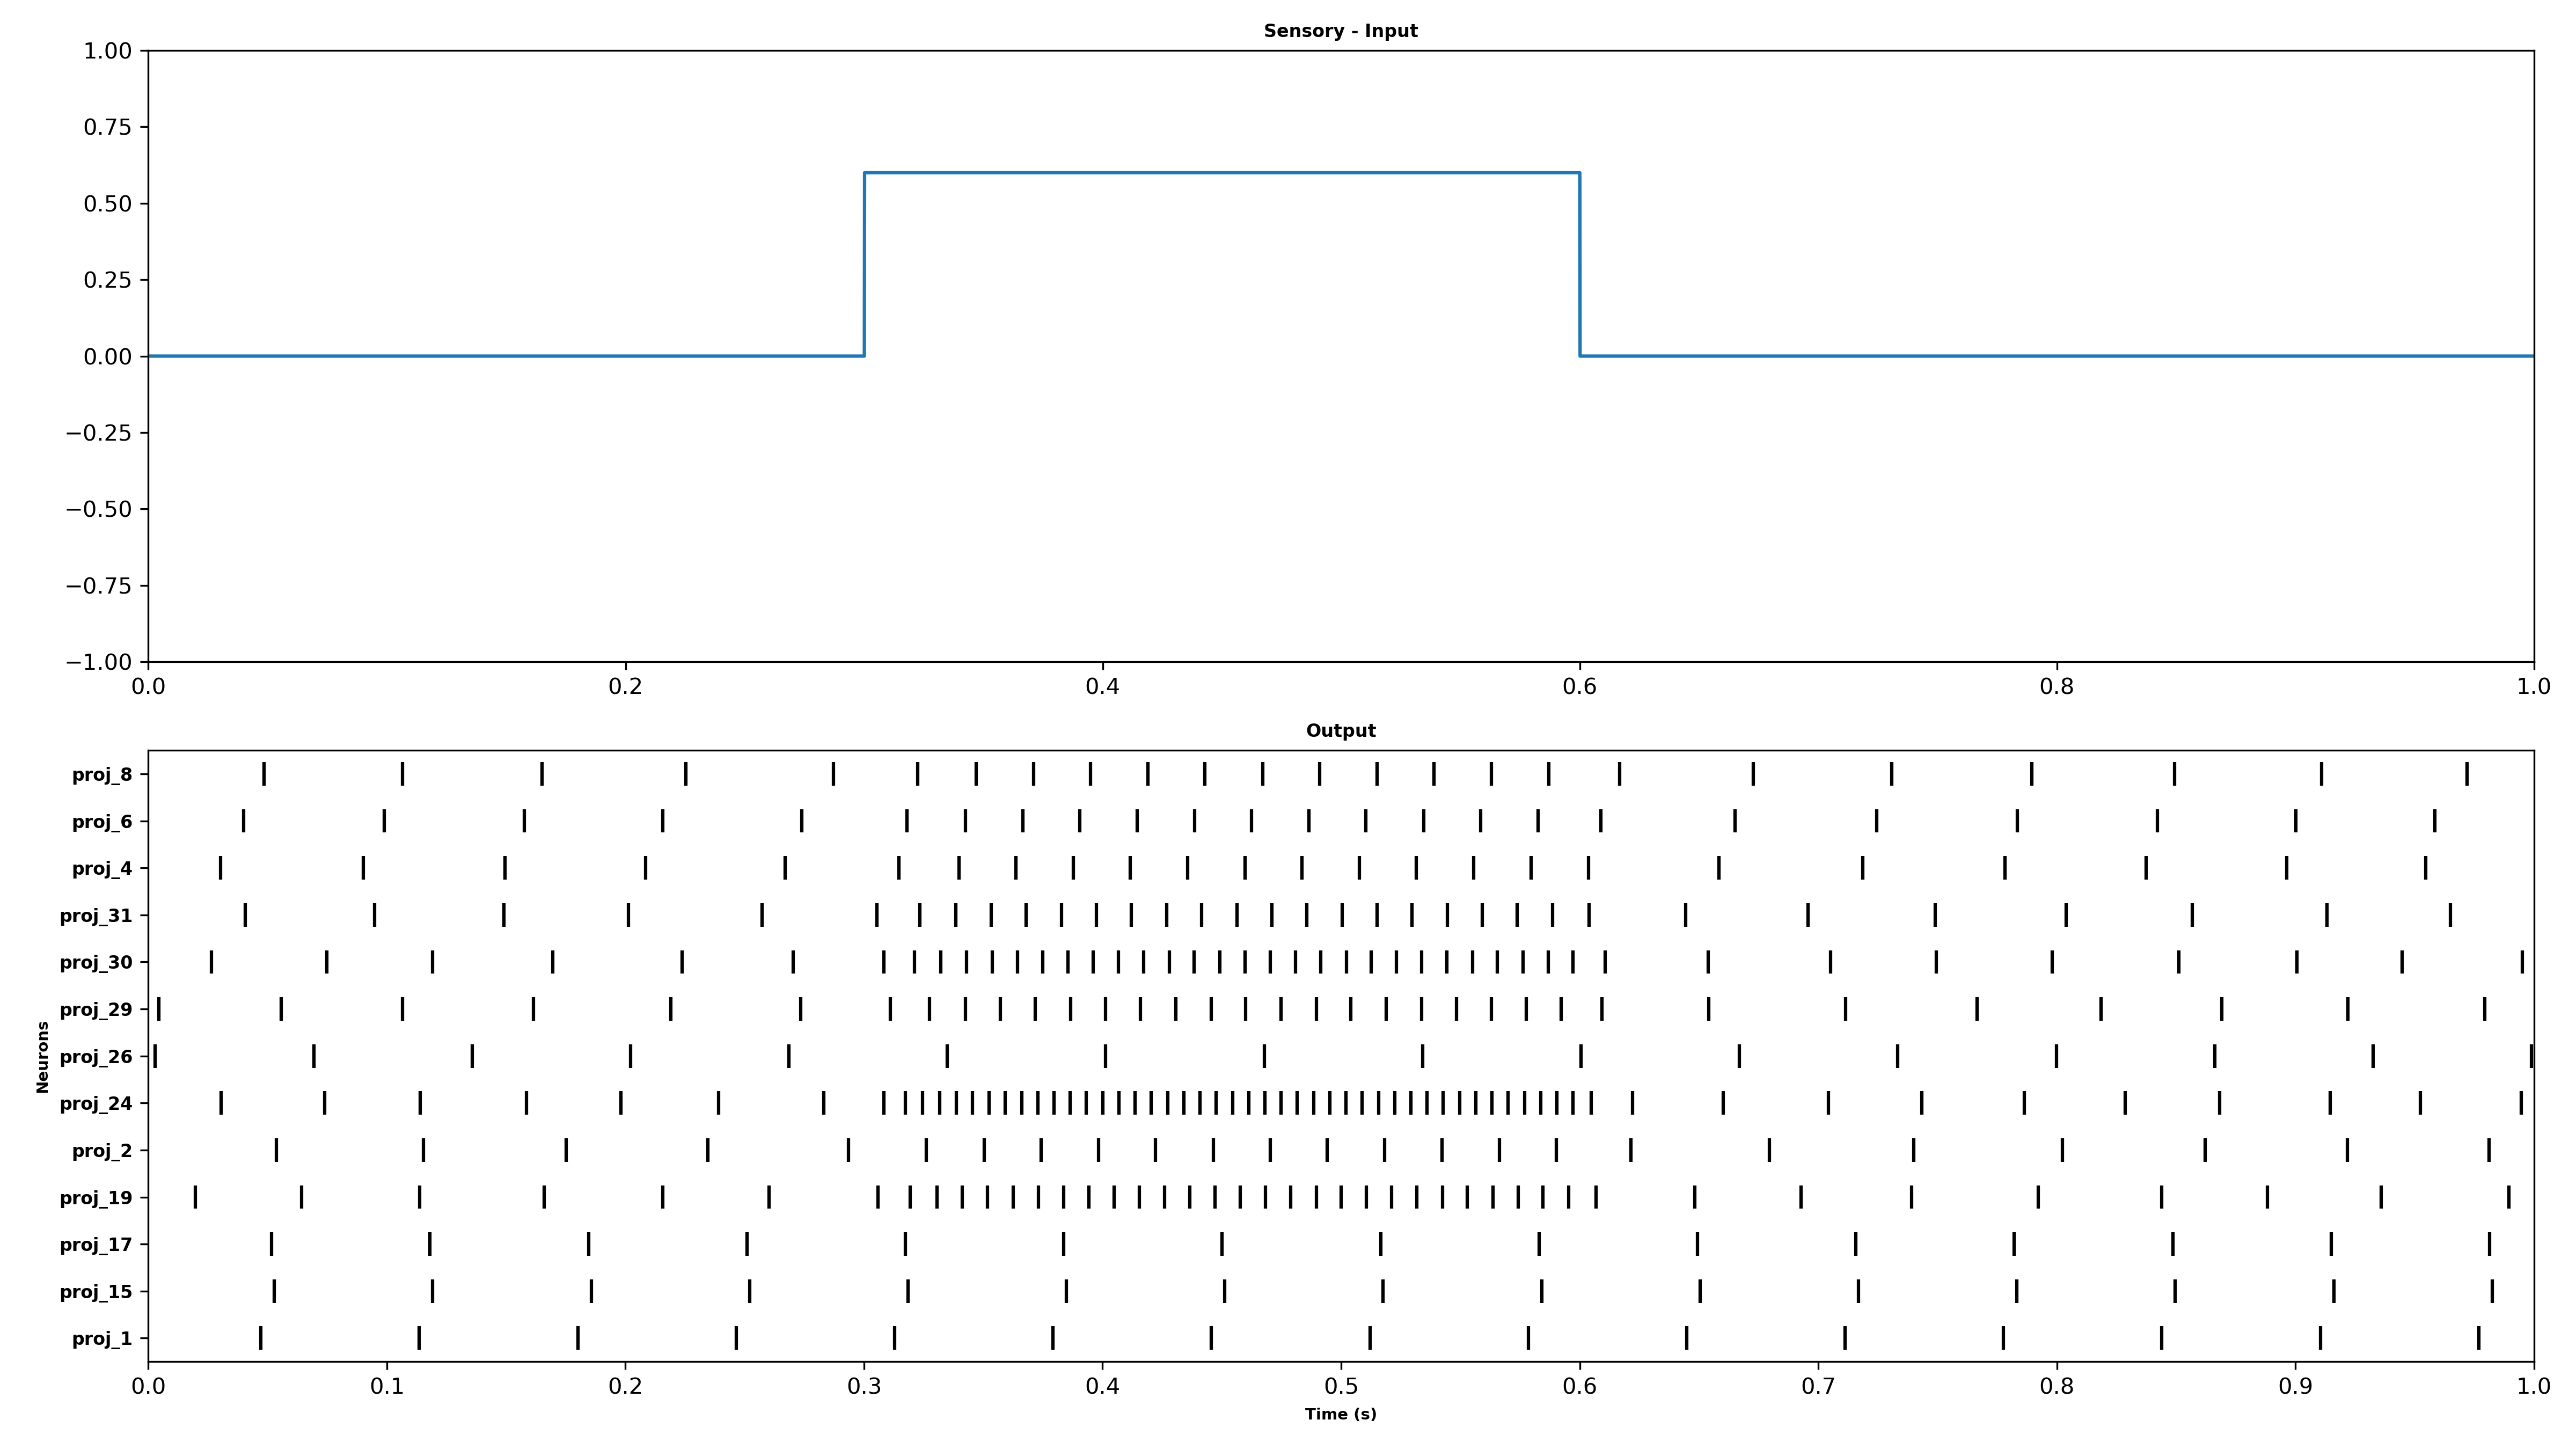

In [4]:
from IPython.display import Image

Image(filename = 'generic_output.png')

We can also create a video for the simulation output using the following variation of the visualization code (requires ffmpeg).

In [5]:
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt

import neurokernel.LPU.utils.visualizer as vis
import networkx as nx
import h5py

# Temporary fix for bug in networkx 1.8:
nx.readwrite.gexf.GEXF.convert_bool = {'false':False, 'False':False,
                                       'true':True, 'True':True}

# Select IDs of spiking projection neurons:
G = nx.read_gexf(lpu_file_name)
neu_proj = sorted([k for k, n in G.node.items() if \
                   n['name'][:4] == 'proj' and \
                   n['class'] == 'LeakyIAF'])

in_uid = 'sensory_0'

N = len(neu_proj)

V = vis.visualizer()
V.add_LPU(in_file_name, LPU='Sensory', is_input=True)
V.add_plot({'type':'waveform', 'uids': [[in_uid]], 'variable':'I'},
           'input_Sensory')

V.add_LPU(out_file_name,  'Generic LPU',
          gexf_file= lpu_file_name)
V.add_plot({'type':'raster', 'uids': [neu_proj], 'variable': 'spike_state',
            'yticks': range(1, 1+N),
            'yticklabels': neu_proj, 'title': 'Output'},
            'Generic LPU')

V.rows = 2
V.cols = 1
V.fontsize = 8
V.xlim = [0, 1.0]
V.out_filename = 'generic_output.mp4'
V.codec = 'mpeg4'
V.run()


A video similar to the following video will be generated to playback the simulation results.

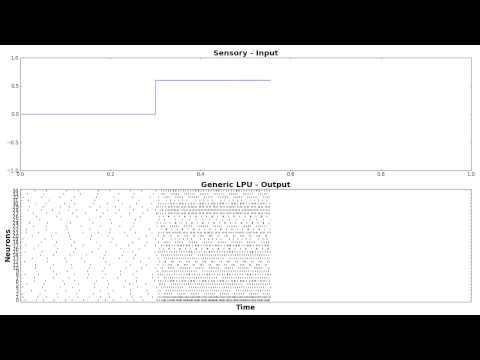

In [6]:
import IPython.display
IPython.display.YouTubeVideo('gIEchSQvffk')

#### Reference

<a name="chiang_three-dimensional_2011" ></a>Ann-Shyn Chiang, Chih-Yung Lin, Chao-Chun Chuang, Hsiu-Ming Chang, Chang- Huain Hsieh, Chang-Wei Yeh, Chi-Tin Shih, Jian-Jheng Wu, Guo-Tzau Wang, and Yung-Chang Chen. Three-dimensional reconstruction of brain-wide wiring networks in Drosophila at single-cell resolution. Current Biology, 21(1):1–11, January 2011.